# Random Forest Regressor from scratch

## Why Random Forest?
`Decision tree` is susceptible to high variance if it is not pruned. 

`Bagging` is the combination of many Decision Tree models, and the prediction follows the crowd; but these tree are highly correlated.

`Random Forest`, the extension of `Bagging`, constrains the features that can be used to build the trees, forcing trees to be different. This, in turn, can give a lift in performance.

`Bagging` and `Random Forest` execute Decision Tree upon a sample with replacement of the training dataset. **Sample with replacement** means that the same row may be chosen and added to samples more than once.

Of that training sample, one-third of it is set aside as test data, known as the out-of-bag (`oob`) sample, used for cross-validation, finalizing that prediction.

**Key Benefits**
- Reduced risk of **overfitting**: Averaging of **uncorrelated trees** lowers the overall **variance** and prediction **error**
- Provides flexibility: Handle both **regression** and **classification** tasks with a high degree of accuracy
- Easy to determine **feature importance**: Gini importance, mean decrease in impurity (MDI) and permutation importance known as mean decrease accuracy (MDA)

**Key Challenges**
- Time-consuming process
- Requires more resources
- More complex

In [17]:
from csv import reader
from math import log,sqrt
from random import randrange, seed
from statistics import mode
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

In [18]:
dataset = [[2.771244718, 1.784783929, 0],
           [1.728571309, 1.169761413, 0.1],
           [3.678319846, 2.81281357, 0.2],
           [3.961043357, 2.61995032, -0.1],
           [2.999208922, 2.209014212, 0.3],
           [7.497545867, 3.162953546, 1.1],
           [9.00220326, 3.339047188, 1.2],
           [7.444542326, 0.476683375, 1.9],
           [10.12493903, 3.234550982, 0.9],
           [6.642287351, 3.319983761, 1.6]]

## Calculating splits

In [19]:
def split_criteria(y, criteria = 'std'):
    """
    split_criteria([1,2,3,4,3], 'std') = std([1,2,3,4,3])
    """
    if criteria == 'std':
        if len(y) == 0: return 0
        return np.std(y)
    if criteria == 'mae':
        u = np.mean(y)
        return np.mean(np.abs(u - y))

group_targets = [[1,2,1],[1,1,2]]
s1, s2 = group_targets
print(split_criteria(s1, 'std'))
print(split_criteria(s1, 'mae'))

0.4714045207910317
0.4444444444444444


In [20]:
def test_split(index, value, dataset):
    """
    Split a dataset based on an attribute and an attribute value.
    Complexity: O(#rows)
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset, n_features, criteria):
    """
    This heuristic algorithm loops all rows (samples) and column (attributes), thus it is painful for computing.
    Complexity: O(#rows^2 x #columns) x O(gini_index)
    """
    attributes = len(dataset[0]) - 1
    retAttribute, retValue, retGroups, min_loss = None, None, None, 999

    features = list()
    counter = 0
    while counter < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            counter = counter + 1
            features.append(index)
    for row in dataset:
        for attribute in features:
            group_left, group_right = test_split(attribute, row[attribute], dataset)
#             group_left, group_right = groups
            target_left = [row[-1] for row in group_left]
            target_right = [row[-1] for row in group_right]

            total = len(target_left) + len(target_right)
            pL = len(target_left) / total
            
            loss =  pL * split_criteria(target_left, criteria) + (1 - pL) * split_criteria(target_right, criteria)
            if loss < min_loss:
                min_loss = loss
                retAttribute, retValue, retGroups = attribute, row[attribute], (group_left, group_right)
    return {'attribute': retAttribute, 'value': retValue, 'groups': retGroups}

get_split(dataset, 2, 'std')


{'attribute': 0,
 'value': 6.642287351,
 'groups': ([[2.771244718, 1.784783929, 0],
   [1.728571309, 1.169761413, 0.1],
   [3.678319846, 2.81281357, 0.2],
   [3.961043357, 2.61995032, -0.1],
   [2.999208922, 2.209014212, 0.3]],
  [[7.497545867, 3.162953546, 1.1],
   [9.00220326, 3.339047188, 1.2],
   [7.444542326, 0.476683375, 1.9],
   [10.12493903, 3.234550982, 0.9],
   [6.642287351, 3.319983761, 1.6]])}

In [21]:
def to_terminal(group):
    assert group, 'group should not be empty'
    outcomes = [row[-1] for row in group]
    return np.mean(outcomes)  # mean of predictions

def split(node, max_depth, min_size, depth, n_features, criteria):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:  # left or right is empty list
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features, criteria)
        split(node['left'], max_depth, min_size, depth+1, n_features, criteria)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features, criteria)
        split(node['right'], max_depth, min_size, depth+1, n_features, criteria)

## Build a tree

In [22]:
def build_tree(train_set, max_depth, min_size, n_features, criteria = 'std'):
	root = get_split(train_set, n_features, criteria)
	split(root, max_depth, min_size, 0, n_features, criteria)
	return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' %
              ((depth*'-', (node['attribute']+1), node['value'])))
        print_tree(node['left'], depth+2)
        print_tree(node['right'], depth+2)
    else:
        print('%s[%s]' % ((depth*'-', node)))  # This is cool!


tree = build_tree(dataset, 6, 1, 1, 'std')
print_tree(tree)

[X2 < 3.163]
--[X2 < 1.170]
----[1.9]
----[X1 < 3.961]
------[X1 < 2.999]
--------[X2 < 1.785]
----------[0.1]
----------[0.0]
--------[X1 < 3.678]
----------[0.3]
----------[0.2]
------[-0.1]
--[X1 < 7.498]
----[1.6]
----[X2 < 3.339]
------[X1 < 10.125]
--------[1.1]
--------[0.9]
------[1.2]


In [23]:
def predict(tree, input_row):  # input is row of testset
    if input_row[tree['attribute']] < tree['value']:
        if isinstance(tree['left'], dict):
            return predict(tree['left'], input_row)
        else:
            return tree['left']
    else:
        if isinstance(tree['right'], dict):
            return predict(tree['right'], input_row)
        else:
            return tree['right']

# Root Mean Square Error
def rmse(y, y_hat):
    if not isinstance(y, np.ndarray):
        y, y_hat = np.array(y), np.array(y_hat)
    return np.mean((y - y_hat)**2)

## Build a forest

In [24]:
def subsample_idx(data_size, sample_size):
    """
    Retrieve from the `dataset` indices *randomly* with `sample_size`
    """
    sample_indices = list()
    counter = 0
    while(counter < sample_size):
        index = randrange(data_size)
        sample_indices.append(index)
        counter += 1
    return sample_indices

def bagging_predict(trees, row):
    return np.mean([predict(tree, row) for tree in trees])  # mean of trees' predictions

def random_forest_regressor(train_set, test_set, max_depth, min_size, n_features, n_trees, sample_size, criteria):
    trees = list()
    for i in range(n_trees):
        sample_indices = subsample_idx(len(train_set), sample_size)
        sample = [train_set[i] for i in sample_indices]
        tree = build_tree(sample, max_depth, min_size, n_features, criteria)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test_set]
    return predictions

print(random_forest_regressor(dataset[:int(len(dataset)*7/10)], dataset[int(len(dataset)*7/10):], 5, 1, 1, 5, 4, 'std'))

[0.08, 0.64, 0.21999999999999997]


## Out-of-bag error

R² score, the coefficient of determination

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

Upperbound (1), lowerbound(may be negative - arbitrarily worse)

In [25]:
def r2_score(y, y_hat):
        y_mean = np.mean(y)
        error_sqr = np.sum((y - y_hat)**2) # error square
        denom = np.sum((y - y_mean)**2)
        R2 = 1 - error_sqr / denom
        return R2
y = np.array([1,2,99,4,4,5])
y_hat = np.array([1,2,3,4,99,-10000])
r2_score(y, y_hat)

-13071.26070115118

In [26]:
def oob_classifier_r2_score(train_set, max_depth, min_size, n_features, n_trees, sample_size, criteria):
    X_train = np.array([x[:-1] for x in train_set])
    y_train = np.array([x[-1] for x in train_set])
    n_samples = len(X_train)

    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    
    for i in range(n_trees):
        # Sampling and collect out-of-bag(oob) indices
        sample_indices = subsample_idx(len(train_set), sample_size)
        oob_indices = np.array([i for i in range(n_samples) if i not in sample_indices])
        
        # Build a tree
        sample = [train_set[i] for i in sample_indices]
        tree = build_tree(sample, max_depth, min_size, n_features, criteria)
        
        # Accumulate prediction value and prediction number over OOB dataset
        tree_preds = [predict(tree, X_train[idx]) for idx in oob_indices]
        predictions[oob_indices] += tree_preds
        n_predictions[oob_indices] +=1

        # Check to avoid divide by zero
        if (n_predictions == 0).any():
            warnings.warn("Too few trees; some variables do not have OOB scores.")
            n_predictions[n_predictions == 0] = 1
            
    predictions /= n_predictions
    return r2_score(y_train, predictions)

## Work with real data

In [27]:
# Load a CSV file
def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column])

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args, metric = rmse):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])  # concatenate lists of lists to a list
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            # test_set use to predict => no need to hold [class] data
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [45]:
seed(1)
# load and prepare data
filename = 'data/sonar.csv' # 0.017
# filename = 'data/BankNote_Authentication.csv' # 0.232
dataset = load_csv(filename)
# remove the string attributes
dataset.pop(0) 

# convert string attributes to float
for i in range(len(dataset[0]) - 1):
    str_column_to_float(dataset, i)

# Check if the last row is not INT{0,1}
if not isinstance(dataset[0][-1], int):
    print("The last row convert from str to int")
    str_column_to_int(dataset, len(dataset[0])-1)

n_folds = 5
max_depth = 5
min_size = 10
n_trees = [1, 5, 10]
n_features = round(sqrt(len(dataset[0]) - 1))
sample_size = len(dataset)
# (train_set, max_depth, min_size, n_features, n_trees, sample_size):
for n_tree in n_trees:
    print('# trees: %s' % n_tree)
    tic = time.perf_counter()
    scores = evaluate_algorithm(dataset, random_forest_regressor, n_folds, max_depth, min_size, n_features, n_tree, sample_size, 'std')
    toc = time.perf_counter()
    print(f"======> Runned in {toc - tic:0.4f} seconds")
    
    print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))
    tic = time.perf_counter()
    oob_score = oob_classifier_r2_score(dataset, max_depth, min_size, n_features, n_tree, sample_size, 'std')
    toc = time.perf_counter()
    print(f"======> Runned in {toc - tic:0.4f} seconds")
    print('OOB_r2_score: %.3f' % oob_score)

The last row convert from str to int
# trees: 1
======> Runned in 3.0230 seconds
Root Mean Square Error: 0.300


/tmp/ipykernel_566/1847774017.py:31: UserWarning: Too few trees; some variables do not have OOB scores.
  warnings.warn("Too few trees; some variables do not have OOB scores.")


======> Runned in 0.6401 seconds
OOB_r2_score: -0.493
# trees: 5
======> Runned in 15.7013 seconds
Root Mean Square Error: 0.165
======> Runned in 3.4775 seconds
OOB_r2_score: -0.032
# trees: 10
======> Runned in 36.4092 seconds
Root Mean Square Error: 0.136
======> Runned in 7.6199 seconds
OOB_r2_score: 0.307


## Work with continuous data

In [28]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    permute = np.random.permutation(len(y))
    return X[permute], y[permute]

def train_test_split_manual(X, y, test_size=0.3):
    nX, ny = shuffle_data(X,y)
    split_index = int(len(X)*test_size)
    testX = nX[:split_index]
    trainX = nX[split_index:]
    testy = ny[:split_index]
    trainy = ny[split_index:]
    return trainX, testX, trainy, testy


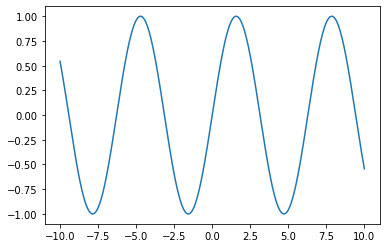

In [29]:
def get_data():
    x = np.linspace(-10,10,500)
    y = np.sin(x)
    return x, y

X,y = get_data()

plt.plot(X,y);

In [32]:
n_trees = 5
n_folds = 5
max_depth = 20  # maximum depth of tree
min_size = 2  # minimum size of 1 group
n_features = round(sqrt(len(dataset[0]) - 1))

# Draw the predictions on the real data
x_train, x_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)
sample_size = len(x_train)
# predictions = decision_tree_regressor(list(zip(x_train, y_train)), \
#                                       list(zip(x_test, y_test)), max_depth, min_size, criteria='mae')
predictions = random_forest_regressor(list(zip(x_train, y_train)),list(zip(x_test, y_test)), 
                                      max_depth, min_size, n_features, n_trees, sample_size, criteria='mae')
# def random_forest_regressor(train_set, test_set, max_depth, min_size, n_features, n_trees, sample_size, criteria):
plt.scatter(x_test,predictions,c='r', marker='^')
plt.plot(X,y);

# # evaluate algorithm
# scores = evaluate_algorithm(
#     list(zip(X,y)), decision_tree_regressor, n_folds, max_depth, min_size, 'std')
# print('Scores: %s' % scores)
# print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))


# n_trees = [1, 5, 10]
# n_features = round(sqrt(len(dataset[0]) - 1))
# sample_size = len(dataset)
# dataset = list(zip(X,y))
# for n_tree in n_trees:
#     print('# trees: %s' % n_tree)
#     tic = time.perf_counter()
#     scores = evaluate_algorithm(dataset, random_forest_regressor, n_folds, max_depth, 
#                                 min_size, n_features, n_tree, sample_size, 'std')
#     toc = time.perf_counter()
#     print(f"======> Runned in {toc - tic:0.4f} seconds")
    
#     print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))
#     tic = time.perf_counter()
#     oob_score = oob_classifier_r2_score(dataset, max_depth, min_size, n_features, 
#                                         n_tree, sample_size, 'std')
#     toc = time.perf_counter()
#     print(f"======> Runned in {toc - tic:0.4f} seconds")
#     print('OOB_r2_score: %.3f' % oob_score)

/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: cannot unpack non-iterable NoneType object

## Conclusion

Version 0.1: 20/09/2021
* Add Out-of-bag(**oob**) error utilizing unsample data for cross-validation (NOT **k cross-validation**), this test is particularly used in `Random Forest` algorithms.
* This OOB_score using **r2_score** function provide the indication of goodness of fit. Best possible score is 1.0, it can be negative (arbitrarily worse)
* OOB_r2_score:
    - -0.493 data/sonar.csv (1 tree)
    - -0.032 data/sonar.csv (5 trees)
    - 0.307 data/sonar.csv (10 trees)
* RMSE:
    - 0.300 data/sonar.csv (1 tree)
    - 0.165 data/sonar.csv (5 trees)
    - 0.136 data/sonar.csv (10 trees)
    
`Question`: Why the running time of RF regressor is very slow compared to that of RF classifier (x4)?
    - Compute std, mae
    - 
    - Compute R2_score

## Refs
https://machinelearningmastery.com/implement-random-forest-scratch-python/

https://www.ibm.com/cloud/learn/random-forest

https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py